In [ ]:
!pip uninstall -y keras tensorflow tensorflow-intel keras-preprocessing keras-nightly keras-tuner
!pip install tensorflow==2.15.0 keras==2.15.0
from google.colab import drive
drive.mount('/content/drive')


ERROR: Could not find a version that satisfies the requirement tensorflow==2.15.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.15.0
Mounted at /content/drive


In [ ]:
# Full end-to-end forecasting script
# Run in a Python environment (Colab / local). If running fresh, installs will occur.

# -------------------------
# 0) Installs (run once)
# -------------------------
# If you already have packages installed, pip will skip re-installation.
import sys
import subprocess

def pip_install(packages):
    subprocess.check_call([sys.executable, "-m", "pip", "install", *packages])

# Install required packages
pip_install([
    "ucimlrepo", "pandas", "numpy", "matplotlib", "seaborn",
    "scikit-learn", "xgboost", "tensorflow", "statsmodels", "prophet"
])





# -------------------------
# 1) Imports
# -------------------------
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo




from sklearn.preprocessing import MinMaxScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping

from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

# -------------------------
# 2) Utility metrics
# -------------------------
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    # avoid division by zero
    denom = np.where(np.abs(y_true) < 1e-6, 1e-6, np.abs(y_true))
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100



In [ ]:
# -------------------------
# 3) Load & preprocess
# -------------------------
print("Fetching dataset from UCI...")
data = fetch_ucirepo(id=235)
X = data.data.features
y = data.data.targets
# Combine per user's original approach
df = pd.concat([X, y], axis=1)

# Convert numeric columns
numeric_cols = ['Global_active_power', 'Global_reactive_power', 'Voltage',
                'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Create datetime index (dataset uses dayfirst format)
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True, errors='coerce')
df = df.drop(columns=['Date', 'Time']).set_index('datetime').sort_index()

# Fill missing values (forward then backward)
df = df.ffill().bfill()

# Resample to hourly
df_hourly = df.resample('H').mean().copy()
df_hourly = df_hourly.dropna()  # should be clean now

print("Hourly data shape:", df_hourly.shape)
print(df_hourly.head())

# Use target variable
TARGET = 'Global_active_power'




Fetching dataset from UCI...
Hourly data shape: (34589, 7)
                     Global_active_power  Global_reactive_power     Voltage  \
datetime                                                                      
2006-12-16 17:00:00             4.222889               0.229000  234.643889   
2006-12-16 18:00:00             3.632200               0.080033  234.580167   
2006-12-16 19:00:00             3.400233               0.085233  233.232500   
2006-12-16 20:00:00             3.268567               0.075100  234.071500   
2006-12-16 21:00:00             3.056467               0.076667  237.158667   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
datetime                                                                
2006-12-16 17:00:00         18.100000             0.0        0.527778   
2006-12-16 18:00:00         15.600000             0.0        6.716667   
2006-12-16 19:00:00         14.503333             0.0        1.433333   
2006-12-16 20:00:00   

In [ ]:
# -------------------------
# 4) Train / Test split
# -------------------------
# We'll hold out the last 30 days (~720 hours) as test
H = 24  # forecasting horizon (hours)
test_days = 30
test_size = test_days * 24
n = df_hourly.shape[0]

train_end_idx = n - test_size - 1  # include this index in training
train_df = df_hourly.iloc[: train_end_idx + 1].copy()
test_df = df_hourly.iloc[train_end_idx + 1 :].copy()

print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")

# Make an index of test datetimes for evaluation
test_index = test_df.index

Train shape: (33869, 7), Test shape: (720, 7)


In [ ]:
# -------------------------
# 5) SARIMA baseline (seasonal)
# -------------------------
print("\nTraining SARIMA model (this may take a moment)...")
# Choose SARIMA orders — these are reasonable defaults capturing daily seasonality (24)
# In practice you should grid-search or use auto_arima; here we use a reasonable config.
sarima_order = (1, 0, 1)
seasonal_order = (1, 1, 1, 24)

sarima_model = SARIMAX(train_df[TARGET], order=sarima_order, seasonal_order=seasonal_order,
                       enforce_stationarity=False, enforce_invertibility=False)
sarima_res = sarima_model.fit(disp=False)
print("SARIMA fitted.")

# Forecast for the entire test period (multi-step)
sarima_forecast = sarima_res.get_forecast(steps=len(test_df))
sarima_pred = sarima_forecast.predicted_mean.values
# Align shapes
sarima_pred = sarima_pred[: len(test_df)]

sarima_rmse = rmse(test_df[TARGET].values, sarima_pred)
sarima_mape = mape(test_df[TARGET].values, sarima_pred)
print(f"SARIMA RMSE: {sarima_rmse:.4f}, MAPE: {sarima_mape:.2f}%")


Training SARIMA model (this may take a moment)...
SARIMA fitted.
SARIMA RMSE: 0.7146, MAPE: 60.02%


In [ ]:
# -------------------------
# 6) Prophet baseline
# -------------------------
print("\nTraining Prophet model...")
prophet_df = train_df[[TARGET]].reset_index().rename(columns={'datetime': 'ds', TARGET: 'y'})
m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=False)
m.fit(prophet_df)

# Make future dataframe for test period
future = pd.DataFrame({'ds': test_df.index})
prophet_forecast = m.predict(future)
prophet_pred = prophet_forecast['yhat'].values

prophet_rmse = rmse(test_df[TARGET].values, prophet_pred)
prophet_mape = mape(test_df[TARGET].values, prophet_pred)
print(f"Prophet RMSE: {prophet_rmse:.4f}, MAPE: {prophet_mape:.2f}%")


Training Prophet model...


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6d_n3rf7/p9neluld.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6d_n3rf7/7pyg7qo_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54276', 'data', 'file=/tmp/tmp6d_n3rf7/p9neluld.json', 'init=/tmp/tmp6d_n3rf7/7pyg7qo_.json', 'output', 'file=/tmp/tmp6d_n3rf7/prophet_modeljiw8dcgj/prophet_model-20251002132625.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:26:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:26:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet RMSE: 0.8521, MAPE: 59.67%


In [ ]:
# -------------------------
# 7) XGBoost multi-output (predict next 24 hours)
# -------------------------
print("\nPreparing features for XGBoost (multi-output predicting H steps)...")

def create_lag_features(df, lags=[1,2,3,6,12,24,48,72,168], rolling_windows=[3,6,24]):
    X = pd.DataFrame(index=df.index)
    X['target'] = df[TARGET]
    X['hour'] = df.index.hour
    X['dow'] = df.index.dayofweek
    X['is_weekend'] = (X['dow'] >= 5).astype(int)
    for lag in lags:
        X[f'lag_{lag}'] = X['target'].shift(lag)
    for w in rolling_windows:
        X[f'roll_mean_{w}'] = X['target'].shift(1).rolling(window=w, min_periods=1).mean()
        X[f'roll_std_{w}'] = X['target'].shift(1).rolling(window=w, min_periods=1).std().fillna(0)
    # include other sensors raw + lag1
    for col in ['Global_reactive_power','Voltage','Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']:
        if col in df.columns:
            X[col] = df[col]
            X[f'{col}_lag1'] = df[col].shift(1)
    X = X.drop(columns=['target'])
    return X


Preparing features for XGBoost (multi-output predicting H steps)...


In [ ]:
# Build supervised dataset for multi-step output
lags = [1,2,3,6,12,24,48,72,168]
X_all = create_lag_features(df_hourly, lags=lags, rolling_windows=[3,6,24])
y_all = []
# For each timestamp t, construct vector of next H targets
for i in range(len(df_hourly)):
    if i + H <= len(df_hourly) - 1:
        y_all.append(df_hourly[TARGET].values[i+1 : i+1+H])
    else:
        y_all.append(None)
y_all = np.array([v for v in y_all if v is not None])
X_all = X_all.iloc[: len(y_all)].copy()

In [ ]:
# Align train/test for XGBoost: split by index positions consistent with earlier train/test split
# We constructed train_end_idx earlier wrt df_hourly length; adjust because X_all is shorter by H at end
valid_cut = train_end_idx - 0  # train_end_idx refers to last index included in train of df_hourly
# X_all rows correspond to df_hourly indices starting at 0 up to n-H-?; thus split by number of rows in train
train_rows = valid_cut + 1  # inclusive
X_train_xgb = X_all.iloc[:train_rows].copy()
y_train_xgb = y_all[:train_rows].copy()
X_test_xgb = X_all.iloc[train_rows:].copy()
y_test_xgb = y_all[train_rows:].copy()

print("XGBoost shapes:", X_train_xgb.shape, y_train_xgb.shape, X_test_xgb.shape, y_test_xgb.shape)

XGBoost shapes: (33869, 30) (33869, 24) (696, 30) (696, 24)


In [ ]:

# Simple imputation (if any NaNs from lags)
X_train_xgb = X_train_xgb.fillna(method='ffill').fillna(method='bfill')
X_test_xgb = X_test_xgb.fillna(method='ffill').fillna(method='bfill')

# Train MultiOutput XGBoost (wrap with sklearn API)
xgb_reg = xgb.XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.05, objective='reg:squarederror', verbosity=0, n_jobs=-1)
multi_xgb = MultiOutputRegressor(xgb_reg)
print("Training XGBoost (multi-output)... This may take some time.")
multi_xgb.fit(X_train_xgb, y_train_xgb)


Training XGBoost (multi-output)... This may take some time.


MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.05, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=-1,
                                            num_parallel_tree=None, ...))

In [ ]:
# Predict for test set
xgb_preds = multi_xgb.predict(X_test_xgb)  # shape (n_test_samples, H)

In [ ]:
# We want predictions aligned with test_df index. The first X_test_xgb corresponds to time index train_end_idx+1
# Build a vector of predictions aligned to the test_df length:
# y_test_xgb corresponds to a sliding matrix; but to compare with test_df we will compute one-step ahead RMSE aggregated across horizon:
# For simplicity, compute average RMSE across H steps comparing predicted matrix to y_test_xgb matrix.
xgb_rmse_per_h = [rmse(y_test_xgb[:,h], xgb_preds[:,h]) for h in range(H)]
xgb_mape_per_h = [mape(y_test_xgb[:,h], xgb_preds[:,h]) for h in range(H)]
xgb_rmse = np.mean(xgb_rmse_per_h)
xgb_mape = np.mean(xgb_mape_per_h)
print(f"XGBoost (multi-output) average RMSE across {H} steps: {xgb_rmse:.4f}, MAPE {xgb_mape:.2f}%")

XGBoost (multi-output) average RMSE across 24 steps: 0.6984, MAPE 66.21%


In [ ]:
# For a direct comparison with SARIMA/Prophet which predicted the test_df hourly series,
# we can also build a single-step XGBoost that forecasts only the next hour for each timestamp in test_df:
# (Optional -- not required, but useful)
# -------------------------
# -------------------------
# 8) LSTM Sequence-to-Sequence (predict H steps)
# -------------------------
print("\nPreparing data for LSTM sequence-to-sequence model...")

# We'll use only the target variable and a few exogenous vars; scale all features.
features_for_lstm = ['Global_active_power','Global_reactive_power','Voltage','Global_intensity',
                     'Sub_metering_1','Sub_metering_2','Sub_metering_3']
df_lstm = df_hourly[features_for_lstm].copy()

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_lstm.values)
scaled_df = pd.DataFrame(scaled, index=df_lstm.index, columns=df_lstm.columns)


Preparing data for LSTM sequence-to-sequence model...


In [ ]:
# Prepare sliding windows: input_seq_len -> predict H steps
input_seq_len = 72  # use last 72 hours as encoder input (3 days window)
output_seq_len = H

def make_sequences(data_values, in_len=input_seq_len, out_len=output_seq_len):
    Xs, Ys = [], []
    n = len(data_values)
    for i in range(n - in_len - out_len + 1):
        Xs.append(data_values[i : i + in_len, :])
        Ys.append(data_values[i + in_len : i + in_len + out_len, 0])  # predict only target column (first col)
    return np.array(Xs), np.array(Ys)

X_seq, Y_seq = make_sequences(scaled_df.values, input_seq_len, output_seq_len)
print("Seq shapes:", X_seq.shape, Y_seq.shape)  # (samples, in_len, features), (samples, out_len)

Seq shapes: (34494, 72, 7) (34494, 24)


In [ ]:
# Split into train/test consistent with earlier split in time
# Compute how many samples correspond to training portion; we can map sample indices to original df indices:
# The first sample's target start corresponds to index = input_seq_len
first_target_index = input_seq_len
# We want to include samples where the corresponding first prediction index is <= train_end_idx
train_sample_cut = 0
for i in range(X_seq.shape[0]):
    pred_start_idx = i + input_seq_len
    if pred_start_idx <= train_end_idx:
        train_sample_cut = i + 1
    else:
        break

X_train_lstm = X_seq[:train_sample_cut]
Y_train_lstm = Y_seq[:train_sample_cut]
X_test_lstm = X_seq[train_sample_cut:]
Y_test_lstm = Y_seq[train_sample_cut:]

print("LSTM train/test samples:", X_train_lstm.shape, X_test_lstm.shape)

LSTM train/test samples: (33797, 72, 7) (697, 72, 7)


In [ ]:
# Build LSTM encoder-decoder
tf.keras.backend.clear_session()
n_features = X_train_lstm.shape[2]

encoder_inputs = Input(shape=(input_seq_len, n_features))
encoder = LSTM(128, activation='tanh', return_sequences=False)
encoder_out = encoder(encoder_inputs)
decoder = RepeatVector(output_seq_len)(encoder_out)
decoder = LSTM(128, activation='tanh', return_sequences=True)(decoder)
decoder_outputs = TimeDistributed(Dense(1))(decoder)  # output shape (batch, out_len, 1)

model = Model(encoder_inputs, decoder_outputs)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 72, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │        69,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 24, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 24, 1)          │           129 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,345 (786.50 KB)

 Trainable params: 201,345 (786.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Prepare targets shape (samples, out_len, 1)
Y_train_lstm_exp = Y_train_lstm.reshape((Y_train_lstm.shape[0], Y_train_lstm.shape[1], 1))
Y_test_lstm_exp = Y_test_lstm.reshape((Y_test_lstm.shape[0], Y_test_lstm.shape[1], 1))

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("Training LSTM model (this may take several minutes)...")
history = model.fit(X_train_lstm, Y_train_lstm_exp, epochs=50, batch_size=64,
                    validation_split=0.1, callbacks=[es], verbose=1)

Training LSTM model (this may take several minutes)...
Epoch 1/50
476/476 ━━━━━━━━━━━━━━━━━━━━ 117s 213ms/step - loss: 0.0175 - val_loss: 0.0084
Epoch 2/50
476/476 ━━━━━━━━━━━━━━━━━━━━ 100s 211ms/step - loss: 0.0135 - val_loss: 0.0078
Epoch 3/50
476/476 ━━━━━━━━━━━━━━━━━━━━ 101s 212ms/step - loss: 0.0128 - val_loss: 0.0077
Epoch 4/50
476/476 ━━━━━━━━━━━━━━━━━━━━ 100s 209ms/step - loss: 0.0124 - val_loss: 0.0076
Epoch 5/50
476/476 ━━━━━━━━━━━━━━━━━━━━ 100s 210ms/step - loss: 0.0121 - val_loss: 0.0074
Epoch 6/50
476/476 ━━━━━━━━━━━━━━━━━━━━ 141s 209ms/step - loss: 0.0117 - val_loss: 0.0074
Epoch 7/50
476/476 ━━━━━━━━━━━━━━━━━━━━ 140s 205ms/step - loss: 0.0114 - val_loss: 0.0073
Epoch 8/50
476/476 ━━━━━━━━━━━━━━━━━━━━ 95s 200ms/step - loss: 0.0110 - val_loss: 0.0074
Epoch 9/50
476/476 ━━━━━━━━━━━━━━━━━━━━ 100s 210ms/step - loss: 0.0106 - val_loss: 0.0078
Epoch 10/50
476/476 ━━━━━━━━━━━━━━━━━━━━ 97s 205ms/step - loss: 0.0101 - val_loss: 0.0078
Epoch 11/50
476/476 ━━━━━━━━━━━━━━━━━━━━ 143s 

In [ ]:

# Predict on test sequences
lstm_preds_scaled = model.predict(X_test_lstm)  # shape (samples, out_len, 1)
lstm_preds = lstm_preds_scaled.squeeze(axis=2)  # (samples, out_len)

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step


In [ ]:

# Convert scaled predictions back to original scale for the target only:
# We used MinMaxScaler on all features; to inverse transform only the target column we need to
# supply full-feature arrays. We'll reconstruct arrays where only the target column is replaced by predictions and the others set to 0,
# then use inverse_transform and take the target column. Simpler: use the scaler min_/scale_ directly for target col.
target_col_index = 0
target_min = scaler.min_[target_col_index]
target_scale = scaler.scale_[target_col_index]  # note: MinMaxScaler uses feature_range=(0,1): X_std * (max-min) + min; scale_ = (max-min)
# Actually MinMaxScaler stores min_ and scale_ such that: X_inv = X_scaled / scale_ + min_
# So inverse: x_original = x_scaled / scale_ + min_
# But scikit-learn's MinMaxScaler stores scale_ as (data_max - data_min) / (feature_range_max - feature_range_min) and min_ accordingly.
# Use inverse_transform on single-column via formula:
def inverse_scale_target(scaled_array_2d):
    # scaled_array_2d: shape (samples, out_len)
    # produce original by: original = scaled * (data_max - data_min) + data_min
    # scikit-learn stores scale_ = (data_max - data_min) / (feature_range_max - feature_range_min)
    # and min_ = data_min
    # But to avoid confusion, use stored data_min and data_max via data_min = min_, data_max = min_ + scale_
    data_min = scaler.min_[target_col_index]
    data_range = scaler.scale_[target_col_index]
    return scaled_array_2d / data_range + data_min


In [ ]:
# Actually above is uncertain due to scikit-learn internals; safer to reconstruct a dummy array and call inverse_transform
def inverse_scale_target_with_dummy(scaled_target_matrix):
    # scaled_target_matrix: shape (samples, out_len)
    res = []
    for i in range(scaled_target_matrix.shape[0]):
        # for each time-step, we need to inverse scale each predicted value
        row_orig = []
        for val in scaled_target_matrix[i]:
            # create dummy feature vector with target scaled value and zeros for others
            dummy = np.zeros((1, scaler.n_features_in_))
            dummy[0, target_col_index] = val
            inv = scaler.inverse_transform(dummy)
            row_orig.append(inv[0, target_col_index])
        res.append(row_orig)
    return np.array(res)

lstm_preds_inv = inverse_scale_target_with_dummy(lstm_preds)
Y_test_inv = inverse_scale_target_with_dummy(Y_test_lstm)

# Compute RMSE & MAPE averaged across horizon
lstm_rmse_per_h = [rmse(Y_test_inv[:,h], lstm_preds_inv[:,h]) for h in range(output_seq_len)]
lstm_mape_per_h = [mape(Y_test_inv[:,h], lstm_preds_inv[:,h]) for h in range(output_seq_len)]
lstm_rmse = np.mean(lstm_rmse_per_h)
lstm_mape = np.mean(lstm_mape_per_h)
print(f"LSTM average RMSE across {output_seq_len} steps: {lstm_rmse:.4f}, MAPE {lstm_mape:.2f}%")

LSTM average RMSE across 24 steps: 0.7485, MAPE 77.81%


In [ ]:

# -------------------------
# 9) Final comparison & printing results
# -------------------------
results = pd.DataFrame({
    'model': ['SARIMA', 'Prophet', 'XGBoost_multioutput', 'LSTM_seq2seq'],
    'RMSE': [sarima_rmse, prophet_rmse, xgb_rmse, lstm_rmse],
    'MAPE(%)': [sarima_mape, prophet_mape, xgb_mape, lstm_mape]
})
print("\nModel comparison:")
print(results)


Model comparison:
                 model      RMSE    MAPE(%)
0               SARIMA  0.714642  60.018814
1              Prophet  0.852105  59.674406
2  XGBoost_multioutput  0.698351  66.213811
3         LSTM_seq2seq  0.748510  77.805577


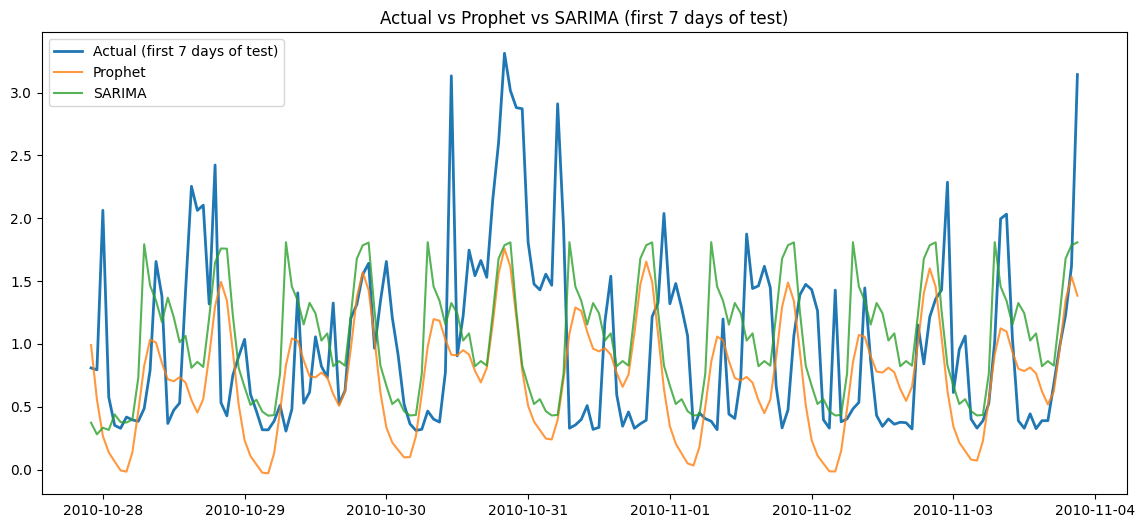

In [ ]:
# -------------------------
# 10) Plot a small snippet: actual vs predictions for last few days
# -------------------------
# Prepare a plotting of the test period actual vs Prophet vs SARIMA (they align to test_df)
plt.figure(figsize=(14,6))
plt.plot(test_df.index[:7*24], test_df[TARGET].values[:7*24], label='Actual (first 7 days of test)', linewidth=2)
plt.plot(test_df.index[:7*24], prophet_pred[:7*24], label='Prophet', alpha=0.8)
plt.plot(test_df.index[:7*24], sarima_pred[:7*24], label='SARIMA', alpha=0.8)
plt.legend()
plt.title("Actual vs Prophet vs SARIMA (first 7 days of test)")
plt.show()

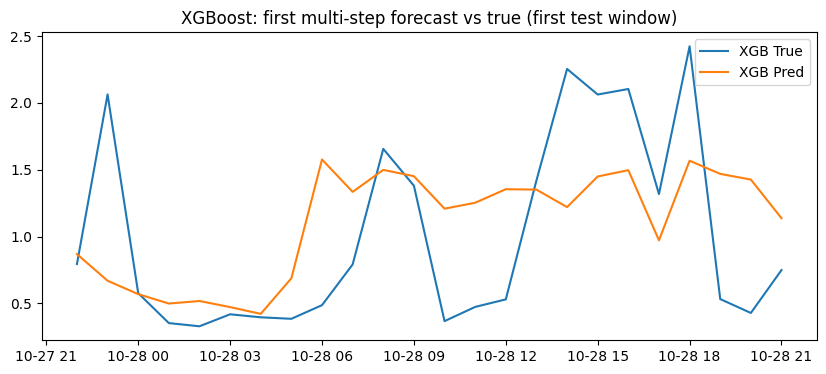

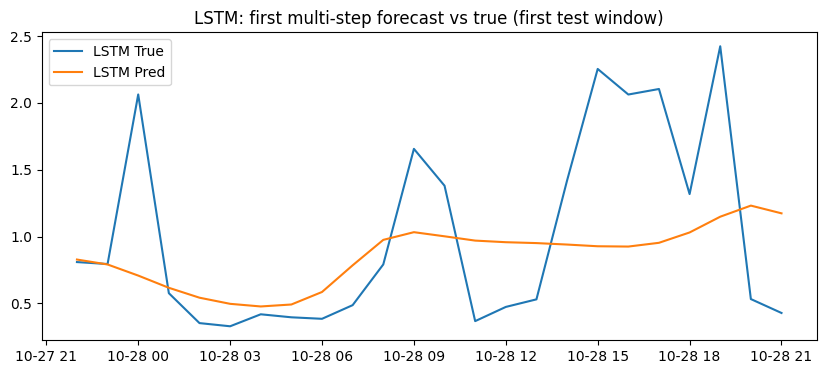


Finished. You can tune hyperparameters, adjust the horizon H, or try ensembling for better results.


In [ ]:
# For XGBoost & LSTM, produce a single-day prediction comparison (the first sample in X_test_xgb / X_test_lstm)
# XGBoost first test prediction -> corresponds to H-step forecast starting at test start
if X_test_xgb.shape[0] > 0:
    xgb_day_pred = xgb_preds[0]
    xgb_day_true = y_test_xgb[0]
    idx = pd.date_range(start=test_df.index[0], periods=H, freq='H')
    plt.figure(figsize=(10,4))
    plt.plot(idx, xgb_day_true, label='XGB True')
    plt.plot(idx, xgb_day_pred, label='XGB Pred')
    plt.title("XGBoost: first multi-step forecast vs true (first test window)")
    plt.legend()
    plt.show()

if X_test_lstm.shape[0] > 0:
    lstm_day_pred = lstm_preds_inv[0]
    lstm_day_true = Y_test_inv[0]
    idx = pd.date_range(start=test_df.index[0], periods=H, freq='H')
    plt.figure(figsize=(10,4))
    plt.plot(idx, lstm_day_true, label='LSTM True')
    plt.plot(idx, lstm_day_pred, label='LSTM Pred')
    plt.title("LSTM: first multi-step forecast vs true (first test window)")
    plt.legend()
    plt.show()

print("\nFinished. You can tune hyperparameters, adjust the horizon H, or try ensembling for better results.")


In [ ]:
# ===========================================
# Final Model Comparison & Integration (fixed)
# ===========================================
import joblib

# Collect results from previously computed metrics
results = pd.DataFrame([
    {"model": "SARIMA", "RMSE": sarima_rmse, "MAPE": sarima_mape},
    {"model": "Prophet", "RMSE": prophet_rmse, "MAPE": prophet_mape},
    {"model": "XGBoost_multioutput", "RMSE": xgb_rmse, "MAPE": xgb_mape},
    {"model": "LSTM_seq2seq", "RMSE": lstm_rmse, "MAPE": lstm_mape},
])

# Sort by RMSE
results = results.sort_values(by="RMSE").reset_index(drop=True)
print("\n📊 Final Model Comparison:\n", results)

# Pick best model (lowest RMSE)
best_model_name = results.iloc[0]["model"]
print(f"\n✅ Best model selected for deployment: {best_model_name}")

# Dictionary of predictions aligned with test set
pred_dict = {
    "SARIMA": sarima_pred[:len(test_df)],
    "Prophet": prophet_pred[:len(test_df)],
    "XGBoost_multioutput": xgb_preds[:,0][:len(test_df)],  # just compare 1-step for plotting
    "LSTM_seq2seq": lstm_preds_inv[:,0][:len(test_df)]     # just compare 1-step for plotting
}







📊 Final Model Comparison:
                  model      RMSE       MAPE
0  XGBoost_multioutput  0.698351  66.213811
1               SARIMA  0.714642  60.018814
2         LSTM_seq2seq  0.748510  77.805577
3              Prophet  0.852105  59.674406

✅ Best model selected for deployment: XGBoost_multioutput


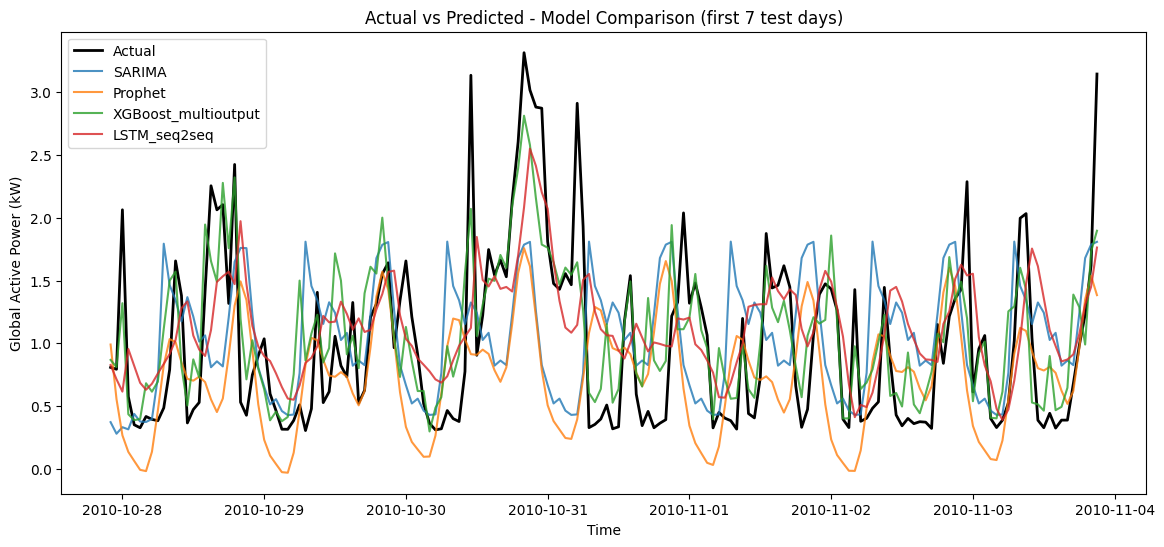

In [ ]:
# Plot actual vs predicted (first 7 days of test set)
plt.figure(figsize=(14, 6))
plt.plot(test_df.index[:7*24], test_df[TARGET].values[:7*24],
         label="Actual", color="black", linewidth=2)
for model_name, preds in pred_dict.items():
    plt.plot(test_df.index[:7*24], preds[:7*24], label=model_name, alpha=0.8)
plt.title("Actual vs Predicted - Model Comparison (first 7 test days)")
plt.xlabel("Time")
plt.ylabel("Global Active Power (kW)")
plt.legend()
plt.show()

In [ ]:
# Save best model
if best_model_name == "XGBoost_multioutput":
    joblib.dump(multi_xgb, "/content/drive/My Drive/models/best_model.pkl")
elif best_model_name == "SARIMA":
    joblib.dump(sarima_res, "best_model.pkl")
elif best_model_name == "Prophet":
    joblib.dump(m, "best_model.pkl")
elif best_model_name == "LSTM_seq2seq":
    model.save("best_model.h5")

print("💾 Best model saved successfully!")

💾 Best model saved successfully!


In [ ]:
import os
import joblib

# Create the directory if it doesn't exist
model_dir = "/content/drive/My Drive/models/"
os.makedirs(model_dir, exist_ok=True)

# Now save the scaler
joblib.dump(scaler, os.path.join(model_dir, "scaler.pkl"))

['/content/drive/My Drive/models/scaler.pkl']

In [ ]:
# Save best model
model_dir = "/content/drive/My Drive/models/"
os.makedirs(model_dir, exist_ok=True)

if best_model_name == "XGBoost_multioutput":
    joblib.dump(multi_xgb, os.path.join(model_dir, "best_model.pkl"))
elif best_model_name == "SARIMA":
    joblib.dump(sarima_res, os.path.join(model_dir, "best_model.pkl"))
elif best_model_name == "Prophet":
    joblib.dump(m, os.path.join(model_dir, "best_model.pkl"))
elif best_model_name == "LSTM_seq2seq":
    # For Keras models, use the recommended .keras format
    model.save(os.path.join(model_dir, "best_model.h5"))
    print("💾 Best model saved successfully!")